<a href="https://colab.research.google.com/github/morteza-sakifard/classification/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Sahpe Of Dataset
### Include Number of Classes & Features

In [ ]:
def get_shape(dataset):
  number_of_classes = dataset.groupby('Class').ngroups
  number_of_features = dataset.loc[:, dataset.columns != 'Class'].columns.size
  return (number_of_classes, number_of_features)

# Mean Of Each Class

In [ ]:
#implemented such as dataset.groupby('Class').mean()
def get_mean(dataset):
  df = pd.DataFrame()
  number_of_classes, number_of_features = get_shape(dataset)
  for class_number in range(1, number_of_classes + 1):
    class_data = dataset[dataset['Class'] == class_number]
    means = {}
    for feature_number in range(1, number_of_features + 1):
      means[f'Feature {feature_number}'] = sum(class_data[f'Feature {feature_number}']) / len(class_data)
    means['Class'] = class_number
    df = df.append(means, ignore_index = True)
  df = df.set_index(['Class'])
  return df

# Covariance Of Each Class

In [ ]:
#implemented such as dataset.groupby('Class').cov()
def get_covariance(dataset):
  df = pd.DataFrame()
  number_of_classes, number_of_features = get_shape(dataset)
  mean = get_mean(dataset)
  for class_number in range(1, number_of_classes + 1):
    class_data = dataset[dataset['Class'] == class_number]
    covariance = {}
    for feature_number in range(1, number_of_features + 1):
      feature_data = class_data[f'Feature {feature_number}']
      variance = sum((feature_data - mean.loc[class_number][f'Feature {feature_number}']) ** 2) / (len(class_data) - 1)
      covariance.setdefault(f'Feature {feature_number}',[]).append(variance)
      for next_feature_number in range(feature_number + 1, number_of_features + 1):
        next_feature_data = class_data[f'Feature {next_feature_number}']
        cov = sum((feature_data - mean.loc[class_number][f'Feature {feature_number}']) * (next_feature_data - mean.loc[class_number][f'Feature {feature_number}'])) / (len(class_data) - 1)
        covariance.setdefault(f'Feature {next_feature_number}',[]).append(cov)
        covariance[f'Feature {feature_number}'].append(cov)
      covariance.setdefault('Class',[]).append(class_number)
    class_df = pd.DataFrame(covariance, index=mean.columns)
    df = df.append(class_df)
  return df

# Likelihood

In [ ]:
def get_liklihood(x, number_of_features, mean, covariance):
  return np.power(2 * np.pi, number_of_features * (-1 / 2)) * np.power(np.linalg.det(covariance), -1 / 2) * np.exp((-1 / 2) * (x - mean).T @ np.linalg.inv(covariance) @ (x - mean))

# Prior

In [ ]:
def get_prior(dataset):
  return dataset.groupby('Class').size() / len(dataset)

# Euclidean Distance

In [ ]:
def get_euclidean_distance(x, mean):
  return np.sqrt((x - mean).T @ (x - mean))

# Mahalanobis Distance

In [ ]:
def get_mahalanobis_distance(x, mean, covariance):
  return np.sqrt((x - mean).T @ np.linalg.inv(covariance) @ (x - mean))

# Confusion Matrix

In [ ]:
def get_confusion_matrix(dataset, classified_labels):
  number_of_classes, number_of_features = get_shape(dataset)
  confusion_matrix = {}
  for class_number in range(1, number_of_classes + 1):
    classification_result = classified_labels[dataset[dataset['Class'] == class_number].index]
    confusion_matrix[class_number] = []
    for predicted_class_number in range(1, number_of_classes + 1):
      confusion_matrix[class_number].append((classification_result == predicted_class_number).sum())
  return pd.DataFrame(confusion_matrix, index=range(1, number_of_classes + 1))

# Evaluate Classifier

In [ ]:
#return accuracy of classifier [Total, Class 1, Class 2, ...]
def evaluate_classifier(dataset, confusion_matrix):
  number_of_classes, number_of_features = get_shape(dataset)
  accuracy = [np.diag(confusion_matrix).sum() / confusion_matrix.sum().sum()]
  for class_number in range(1, number_of_classes + 1):
    accuracy.append(confusion_matrix[class_number][class_number] / confusion_matrix[class_number].sum())
  return accuracy

# Print Evaluation

In [ ]:
def print_evaluation(dataset, accuracy):
  number_of_classes, number_of_features = get_shape(dataset)
  labels = ['Total Accuracy']
  labels += [f'Accuracy Class {class_number}' for class_number in range(1, number_of_classes + 1)]
  percentage_format = ['{:,.0%}'.format for class_number in range(number_of_classes + 1)]
  df = pd.DataFrame(accuracy, index=labels).T
  df = df.style.format(dict(zip(labels, percentage_format)))
  return df

# Maximum Likelihood Classifier

In [ ]:
def classify_with_maximum_liklihood(dataset):
  number_of_classes, number_of_features = get_shape(dataset)
  covariance = get_covariance(dataset)
  mean = get_mean(dataset)
  classified_labels = []
  for index, row in dataset.iterrows():
    classified_row = []
    for class_number in range(1, number_of_classes + 1):
      class_covariance = covariance[covariance['Class'] == class_number].loc[:, covariance.columns != 'Class']
      class_mean = mean.loc[class_number]
      liklihood = get_liklihood(row[:number_of_features], number_of_features, class_mean, class_covariance)
      classified_row.append(liklihood)
    maximum_liklihood = np.argmax(classified_row)
    predict_class = maximum_liklihood + 1
    classified_labels.append(predict_class)
  return np.array(classified_labels)

# Maximum A Posterior Classifier

In [ ]:
def classify_with_maximum_a_posterior(dataset):
  number_of_classes, number_of_features = get_shape(dataset)
  covariance = get_covariance(dataset)
  mean = get_mean(dataset)
  prior = get_prior(dataset)
  classified_labels = []
  for index, row in dataset.iterrows():
    classified_row = []
    for class_number in range(1, number_of_classes + 1):
      class_covariance = covariance[covariance['Class'] == class_number].loc[:, covariance.columns != 'Class']
      class_mean = mean.loc[class_number]
      liklihood = get_liklihood(row[:number_of_features], number_of_features, class_mean, class_covariance)
      posterior = liklihood * prior[class_number]
      classified_row.append(posterior)
    maximum_posterior_index = np.argmax(classified_row)
    predict_class = maximum_posterior_index + 1
    classified_labels.append(predict_class)
  return np.array(classified_labels)

# Bayesian Classifier

In [ ]:
def classify_with_Bayesian(dataset, cost_function):
  number_of_classes, number_of_features = get_shape(dataset)
  covariance = get_covariance(dataset)
  mean = get_mean(dataset)
  prior = get_prior(dataset)
  classified_labels = []
  for index, row in dataset.iterrows():
    classified_row = []
    for class_number in range(1, number_of_classes + 1):
      class_covariance = covariance[covariance['Class'] == class_number].loc[:, covariance.columns != 'Class']
      class_mean = mean.loc[class_number]
      liklihood = get_liklihood(row[:number_of_features], number_of_features, class_mean, class_covariance)
      cost = cost_function.loc[3 - class_number][class_number] - cost_function.loc[class_number][class_number]
      posterior = liklihood * prior[class_number] * cost
      classified_row.append(posterior)
    maximum_posterior_index = np.argmax(classified_row)
    predict_class = maximum_posterior_index + 1
    classified_labels.append(predict_class)
  return np.array(classified_labels)

## Reformat Cost Function

In [ ]:
def reformat_cost_function(cost_function):
  number_of_classes, number_of_features = get_shape(dataset)
  return pd.DataFrame(cost_function, columns=range(1, number_of_classes + 1), index=range(1, number_of_classes + 1))

# Minimum Euclidean Distance Classifier

In [ ]:
def classify_with_minimum_euclidean_distance(dataset):
  number_of_classes, number_of_features = get_shape(dataset)
  mean = get_mean(dataset)
  classified_labels = []
  for index, row in dataset.iterrows():
    classified_row = []
    for class_number in range(1, number_of_classes + 1):
      class_mean = mean.loc[class_number]
      euclidean_distance = get_euclidean_distance(row[:number_of_features], class_mean)
      classified_row.append(euclidean_distance)
    minimum_euclidean_distance_index = np.argmin(classified_row)
    predict_class = minimum_euclidean_distance_index + 1
    classified_labels.append(predict_class)
  return np.array(classified_labels)

# Minimum Mahalanobis Distance Classifier

In [ ]:
def classify_with_minimum_mahalanobis_distance(dataset):
  number_of_classes, number_of_features = get_shape(dataset)
  covariance = get_covariance(dataset)
  mean = get_mean(dataset)
  classified_labels = []
  for index, row in dataset.iterrows():
    classified_row = []
    for class_number in range(1, number_of_classes + 1):
      class_covariance = covariance[covariance['Class'] == class_number].loc[:, covariance.columns != 'Class']
      class_mean = mean.loc[class_number]
      mahalanobis_distance = get_mahalanobis_distance(row[:number_of_features], class_mean, class_covariance)
      classified_row.append(mahalanobis_distance)
    minimum_mahalanobis_distance_index = np.argmin(classified_row)
    predict_class = minimum_mahalanobis_distance_index + 1
    classified_labels.append(predict_class)
  return np.array(classified_labels)

# Sample Dataset 

## Load Dataset

,Feature 1,Feature 2,Class
0,0.463469,-1.821283,1.0
1,0.278755,0.245065,1.0
2,0.135676,0.697622,1.0
3,0.217432,-1.380316,1.0
4,-0.551252,-0.208773,1.0


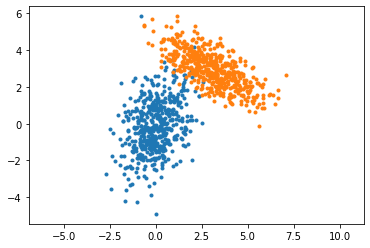

In [ ]:
mean = [0, 0]
cov = [[1, 0.5], [0.5, 2]] #[[1, 0], [0, 1]]
first_class_data = np.random.multivariate_normal(mean, cov, 500)
first_class_data = np.c_[first_class_data, np.ones(first_class_data.shape[0])]
plt.plot(first_class_data[:, 0], first_class_data[:, 1], '.')
plt.axis('equal')

mean = [3, 3]
cov = [[2, -1], [-1, 1]] #[[1, 0], [0, 1]]
second_class_data = np.random.multivariate_normal(mean, cov, 500)
second_class_data = np.c_[second_class_data, np.ones(second_class_data.shape[0]) * 2]
plt.plot(second_class_data[:, 0], second_class_data[:, 1], '.')
plt.axis('equal')

dataset = pd.DataFrame(np.concatenate((first_class_data, second_class_data)))
dataset.columns = ['Feature 1', 'Feature 2', 'Class']
dataset.head()

## Classification With Minimum Euclidean Distance

In [ ]:
classified_labels = classify_with_minimum_euclidean_distance(dataset)

### Minimum Euclidean Distance Confustion Matrix

In [ ]:
confusion_matrix = get_confusion_matrix(dataset, classified_labels)
print('Confusion Matrix: Rows is Classification Result and Columns is Reality')
confusion_matrix

Confusion Matrix: Rows is Classification Result and Columns is Reality


,1,2
1,468,0
2,32,500


### Minimum Euclidean Distance Evaluation

In [ ]:
accuracy = {}
accuracy['Minimum Euclidean Distance'] = evaluate_classifier(dataset, confusion_matrix)

## Classification With Minimum Mahalanobis Distance

In [ ]:
classified_labels = classify_with_minimum_mahalanobis_distance(dataset)

### Minimum Mahalanobis Distance Confustion Matrix

In [ ]:
confusion_matrix = get_confusion_matrix(dataset, classified_labels)
print('Confusion Matrix: Rows is Classification Result and Columns is Reality')
confusion_matrix

Confusion Matrix: Rows is Classification Result and Columns is Reality


,1,2
1,488,3
2,12,497


### Minimum Mahalanobis Distance Evaluation

In [ ]:
accuracy['Minimum Mahalanobis Distance'] = evaluate_classifier(dataset, confusion_matrix)

## Classification With Maximum Likelihood

In [ ]:
classified_labels = classify_with_maximum_liklihood(dataset)

### Maximum Likelihood Confustion Matrix

In [ ]:
confusion_matrix = get_confusion_matrix(dataset, classified_labels)
print('Confusion Matrix: Rows is Classification Result and Columns is Reality')
confusion_matrix

Confusion Matrix: Rows is Classification Result and Columns is Reality


,1,2
1,484,3
2,16,497


### Maximum Likelihood Evaluation

In [ ]:
accuracy['Maximum Likelihood'] = evaluate_classifier(dataset, confusion_matrix)

## Classification With Maximum A Posterior

In [ ]:
classified_labels = classify_with_maximum_a_posterior(dataset)

### Maximum A Posterior Confustion Matrix

In [ ]:
confusion_matrix = get_confusion_matrix(dataset, classified_labels)
print('Confusion Matrix: Rows is Classification Result and Columns is Reality')
confusion_matrix

Confusion Matrix: Rows is Classification Result and Columns is Reality


,1,2
1,484,3
2,16,497


### Maximum A Posterior Evaluation

In [ ]:
accuracy['Maximum A Posterior'] = evaluate_classifier(dataset, confusion_matrix)

## Evaluation

In [ ]:
print_evaluation(dataset, accuracy)

,Total Accuracy,Accuracy Class 1,Accuracy Class 2
Minimum Euclidean Distance,97%,94%,100%
Minimum Mahalanobis Distance,98%,98%,99%
Maximum Likelihood,98%,97%,99%
Maximum A Posterior,98%,97%,99%


# Haberman's Survival Dataset 

## Load Dataset

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pattern Recognition/Dataset/Haberman/haberman.data', sep=',', header=None)
dataset.columns = ['Feature 1', 'Feature 2', 'Feature 3', 'Class']
dataset.head()

,Feature 1,Feature 2,Feature 3,Class
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


## Classification With Minimum Euclidean Distance

In [ ]:
classified_labels = classify_with_minimum_euclidean_distance(dataset)

### Minimum Euclidean Distance Confustion Matrix

In [ ]:
confusion_matrix = get_confusion_matrix(dataset, classified_labels)
print('Confusion Matrix: Rows is Classification Result and Columns is Reality')
confusion_matrix

Confusion Matrix: Rows is Classification Result and Columns is Reality


,1,2
1,175,38
2,50,43


### Minimum Euclidean Distance Evaluation

In [ ]:
accuracy = {}
accuracy['Minimum Euclidean Distance'] = evaluate_classifier(dataset, confusion_matrix)

## Classification With Minimum Mahalanobis Distance

In [ ]:
classified_labels = classify_with_minimum_mahalanobis_distance(dataset)

### Minimum Mahalanobis Distance Confustion Matrix

In [ ]:
confusion_matrix = get_confusion_matrix(dataset, classified_labels)
print('Confusion Matrix: Rows is Classification Result and Columns is Reality')
confusion_matrix

Confusion Matrix: Rows is Classification Result and Columns is Reality


,1,2
1,160,30
2,65,51


### Minimum Mahalanobis Distance Evaluation

In [ ]:
accuracy['Minimum Mahalanobis Distance'] = evaluate_classifier(dataset, confusion_matrix)

## Classification With Maximum Likelihood

In [ ]:
classified_labels = classify_with_maximum_liklihood(dataset)

### Maximum Likelihood Confustion Matrix

In [ ]:
confusion_matrix = get_confusion_matrix(dataset, classified_labels)
print('Confusion Matrix: Rows is Classification Result and Columns is Reality')
confusion_matrix

Confusion Matrix: Rows is Classification Result and Columns is Reality


,1,2
1,195,48
2,30,33


### Maximum Likelihood Evaluation

In [ ]:
accuracy['Maximum Likelihood'] = evaluate_classifier(dataset, confusion_matrix)

## Classification With Maximum A Posterior

In [ ]:
classified_labels = classify_with_maximum_a_posterior(dataset)

### Maximum A Posterior Confustion Matrix

In [ ]:
confusion_matrix = get_confusion_matrix(dataset, classified_labels)
print('Confusion Matrix: Rows is Classification Result and Columns is Reality')
confusion_matrix

Confusion Matrix: Rows is Classification Result and Columns is Reality


,1,2
1,215,63
2,10,18


### Maximum A Posterior Evaluation

In [ ]:
accuracy['Maximum A Posterior'] = evaluate_classifier(dataset, confusion_matrix)

## Classification With Bayesian

In [ ]:
cost_function = reformat_cost_function([[0, 2], [1, 0]])

In [ ]:
classified_labels = classify_with_Bayesian(dataset, cost_function)

### Bayesian Confustion Matrix

In [ ]:
confusion_matrix = get_confusion_matrix(dataset, classified_labels)
print('Confusion Matrix: Rows is Classification Result and Columns is Reality')
confusion_matrix

Confusion Matrix: Rows is Classification Result and Columns is Reality


,1,2
1,204,56
2,21,25


### Bayesian Evaluation

In [ ]:
accuracy['Bayesian'] = evaluate_classifier(dataset, confusion_matrix)

## Evaluation

In [ ]:
print_evaluation(dataset, accuracy)

,Total Accuracy,Accuracy Class 1,Accuracy Class 2
Minimum Euclidean Distance,71%,78%,53%
Minimum Mahalanobis Distance,69%,71%,63%
Maximum Likelihood,75%,87%,41%
Maximum A Posterior,76%,96%,22%
Bayesian,75%,91%,31%


# User Modeling Dataset 

## Load Dataset

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pattern Recognition/Dataset/Data_User_Modeling_Dataset.txt', sep='	', header=None)
dataset.columns = ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5', 'Class']
dataset.head()

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Class
0,0.08,0.08,0.10,0.24,0.90,1
1,0.06,0.06,0.05,0.25,0.33,2
2,0.10,0.10,0.15,0.65,0.30,3
3,0.08,0.08,0.08,0.98,0.24,2
4,0.09,0.15,0.40,0.10,0.66,3


## Classification With Minimum Euclidean Distance

In [ ]:
classified_labels = classify_with_minimum_euclidean_distance(dataset)

### Minimum Euclidean Distance Confustion Matrix

In [ ]:
confusion_matrix = get_confusion_matrix(dataset, classified_labels)
print('Confusion Matrix: Rows is Classification Result and Columns is Reality')
confusion_matrix

Confusion Matrix: Rows is Classification Result and Columns is Reality


,1,2,3,4
1,52,0,2,0
2,0,57,18,3
3,11,12,68,0
4,0,14,0,20


### Minimum Euclidean Distance Evaluation

In [ ]:
accuracy = {}
accuracy['Minimum Euclidean Distance'] = evaluate_classifier(dataset, confusion_matrix)

## Classification With Minimum Mahalanobis Distance

In [ ]:
classified_labels = classify_with_minimum_mahalanobis_distance(dataset)

### Minimum Mahalanobis Distance Confustion Matrix

In [ ]:
confusion_matrix = get_confusion_matrix(dataset, classified_labels)
print('Confusion Matrix: Rows is Classification Result and Columns is Reality')
confusion_matrix

Confusion Matrix: Rows is Classification Result and Columns is Reality


,1,2,3,4
1,62,0,1,0
2,0,81,4,2
3,1,0,83,0
4,0,2,0,21


### Minimum Mahalanobis Distance Evaluation

In [ ]:
accuracy['Minimum Mahalanobis Distance'] = evaluate_classifier(dataset, confusion_matrix)

## Classification With Maximum Likelihood

In [ ]:
classified_labels = classify_with_maximum_liklihood(dataset)

### Maximum Likelihood Confustion Matrix

In [ ]:
confusion_matrix = get_confusion_matrix(dataset, classified_labels)
print('Confusion Matrix: Rows is Classification Result and Columns is Reality')
confusion_matrix

Confusion Matrix: Rows is Classification Result and Columns is Reality


,1,2,3,4
1,62,0,1,0
2,0,78,4,1
3,1,0,83,0
4,0,5,0,22


### Maximum Likelihood Evaluation

In [ ]:
accuracy['Maximum Likelihood'] = evaluate_classifier(dataset, confusion_matrix)

## Classification With Maximum A Posterior

In [ ]:
classified_labels = classify_with_maximum_a_posterior(dataset)

### Maximum A Posterior Confustion Matrix

In [ ]:
confusion_matrix = get_confusion_matrix(dataset, classified_labels)
print('Confusion Matrix: Rows is Classification Result and Columns is Reality')
confusion_matrix

Confusion Matrix: Rows is Classification Result and Columns is Reality


,1,2,3,4
1,62,0,1,0
2,0,82,4,2
3,1,0,83,0
4,0,1,0,21


### Maximum A Posterior Evaluation

In [ ]:
accuracy['Maximum A Posterior'] = evaluate_classifier(dataset, confusion_matrix)

## Evaluation

In [ ]:
print_evaluation(dataset, accuracy)

,Total Accuracy,Accuracy Class 1,Accuracy Class 2,Accuracy Class 3,Accuracy Class 4
Minimum Euclidean Distance,77%,83%,69%,77%,87%
Minimum Mahalanobis Distance,96%,98%,98%,94%,91%
Maximum Likelihood,95%,98%,94%,94%,96%
Maximum A Posterior,96%,98%,99%,94%,91%
